In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load the CSV data
import os
# from zipfile import ZipFile


# zip_file = ZipFile("./solarwind.zip")
# zip_file.extractall()
csv_path = "/kaggle/input/solarwind/solarwind.csv"

# Load the CSV data
data = pd.read_csv(csv_path)
data.head()


,datetime,pressure,temperature_2m,wind_speed_10m,wind_speed_50m,wind_speed_150m,temperature_122m,roughness_length,power_output,global_horizontal_irradiance,...,optimal_dc_power,optimal_dc_voltage,inverter_overpower_loss,inverter_underpower_loss,inverter_overvoltage_loss,inverter_undervoltage_loss,actual_dc_power,actual_dc_voltage,ac_power,grid_power
0,2021-01-01 00:00:00,99140.000000,273.730000,2.280000,4.150000,3.900000,272.950000,0.15,1.551912e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 00:01:00,99139.333333,273.727167,2.278167,4.144667,3.897667,272.947167,0.15,1.549410e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 00:02:00,99138.666667,273.724333,2.276333,4.139333,3.895333,272.944333,0.15,1.546908e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 00:03:00,99138.000000,273.721500,2.274500,4.134000,3.893000,272.941500,0.15,1.544405e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 00:04:00,99137.333333,273.718667,2.272667,4.128667,3.890667,272.938667,0.15,1.541903e+06,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:

# Select the relevant columns for training
selected_columns = ['pressure', 'temperature_2m', 'wind_speed_10m', 'wind_speed_50m', 'wind_speed_150m', 'temperature_122m', 'roughness_length', 'power_output', 'global_horizontal_irradiance', 'direct_normal_irradiance', 'diffuse_horizontal_irradiance', 'dry_bulb_temperature', 'windspeed', 'albedo', 'solar_altitude_angle', 'solar_azimuth_angle', 'solar_incident_angle', 'horizon_elevation_angle', 'tracker_roll_angle', 'adjusted_ghi', 'poa_direct_irradiance', 'poa_diffuse_irradiance', 'poa_reflected_irradiance', 'shaded_direct_irradiance', 'shaded_diffuse_irradiance', 'shaded_reflected_irradiance', 'effective_direct_irradiance', 'effective_diffuse_irradiance', 'effective_reflected_irradiance', 'soiled_irradiance', 'total_irradiance', 'nameplate_power', 'avg_cell_temp', 'module_irradiance_derated_power', 'module_mpp_power', 'module_power', 'optimizer_input_power', 'optimizer_output_power', 'optimal_dc_power', 'optimal_dc_voltage', 'inverter_overpower_loss', 'inverter_underpower_loss', 'inverter_overvoltage_loss', 'inverter_undervoltage_loss', 'actual_dc_power', 'actual_dc_voltage', 'ac_power', 'grid_power']
train_data = data[selected_columns]

# Normalize the data using MinMaxScaler from scikit-learn
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)


# Split the data into train and test sets
train_size = int(len(train_data_scaled) * 0.8)
train_X, test_X = train_data_scaled[:train_size], train_data_scaled[train_size:]
train_y, test_y = train_data_scaled[:train_size], train_data_scaled[train_size:]

# Reshape the input data for the LSTM model
time_steps = 10
train_X = np.array([train_X[i : i + time_steps] for i in range(len(train_X) - time_steps)])
train_y = np.array([train_y[i + time_steps] for i in range(len(train_y) - time_steps)])
test_X = np.array([test_X[i : i + time_steps] for i in range(len(test_X) - time_steps)])
test_y = np.array([test_y[i + time_steps] for i in range(len(test_y) - time_steps)])




In [21]:
# Build the LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(keras.layers.Dense(train_y.shape[1]))

# Compile the model
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                10368     
                                                                 
 dense_1 (Dense)             (None, 48)                1584      
                                                                 
Total params: 11,952
Trainable params: 11,952
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Train the model
# history = model.fit(train_X, train_y, epochs=1, batch_size=8, verbose=1)

history = model.fit(
      train_X, train_y,
      epochs=2,
      validation_split=0.2,
      batch_size=8, verbose=1,
      callbacks=[es_callback, modelckpt_callback]
  )



Epoch 1/2
42041/42043 [============================>.] - ETA: 0s - loss: 1.7512e-04 - accuracy: 0.9394
Epoch 1: val_loss improved from inf to 0.00002, saving model to model_checkpoint.h5
42043/42043 [==============================] - 330s 8ms/step - loss: 1.7512e-04 - accuracy: 0.9394 - val_loss: 1.9551e-05 - val_accuracy: 0.9556
Epoch 2/2
42037/42043 [============================>.] - ETA: 0s - loss: 6.4683e-06 - accuracy: 0.9615
Epoch 2: val_loss improved from 0.00002 to 0.00002, saving model to model_checkpoint.h5
42043/42043 [==============================] - 301s 7ms/step - loss: 6.4680e-06 - accuracy: 0.9615 - val_loss: 1.6485e-05 - val_accuracy: 0.9717


In [23]:
print(history.history['loss'])
print(history.history['val_loss'])

[0.0001751186209730804, 6.467962975875707e-06]
[1.9550529032130726e-05, 1.648458965064492e-05]


In [24]:

# Get the predicted values
train_pred = model.predict(train_X)
test_pred = model.predict(test_X)

# Calculate the residuals
train_residuals = train_y - train_pred
test_residuals = test_y - test_pred


3285/3285 [==============================] - 11s 3ms/step


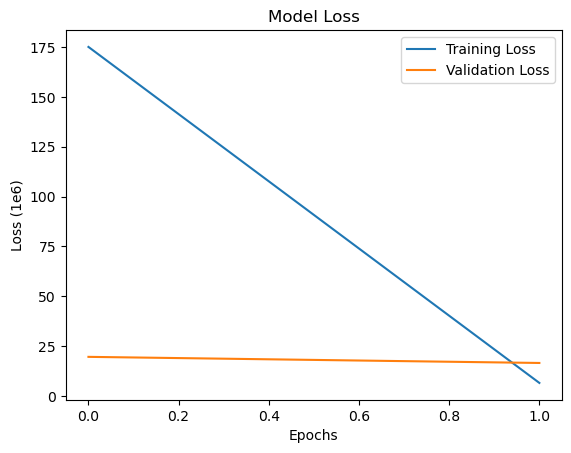

In [25]:
scaled_loss = [loss * 1e6 for loss in history.history['loss']]
scaled_val_loss = [val_loss * 1e6 for val_loss in history.history['val_loss']]


# Plot the training loss and validation loss
plt.plot(scaled_loss, label='Training Loss')
plt.plot(scaled_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (1e6)')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

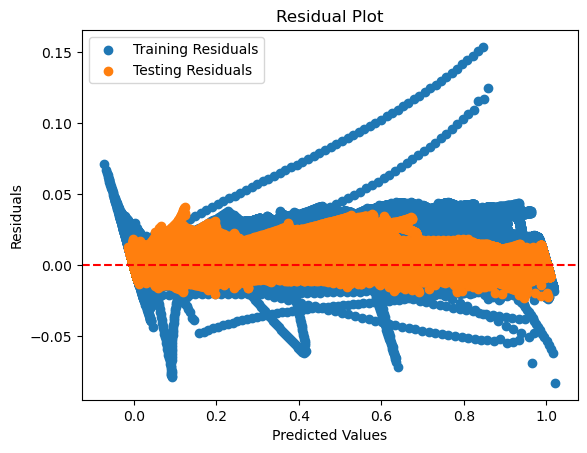

In [29]:
# Plot the residuals
plt.scatter(train_pred, train_residuals, label='Training Residuals')
plt.scatter(test_pred, test_residuals, label='Testing Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

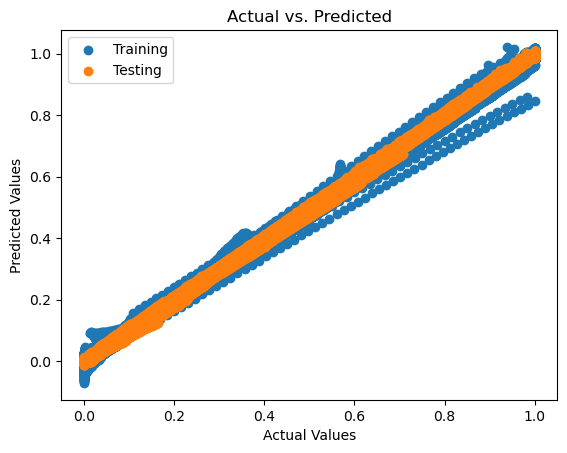

In [30]:
# Plot the actual vs. predicted values
plt.scatter(train_y, train_pred, label='Training')
plt.scatter(test_y, test_pred, label='Testing')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()